In [21]:
import gym
import torch
from torch import nn, optim
import numpy as np
from IPython.display import clear_output
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
USE_GPU = True
NUM_EPISODES = 30000
BATCH_SIZE = 10
GAMMA = 0.95
LR = .001
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY = .995
MEMORY_CAPACITY = 2000

In [23]:
env_mc = "MountainCar-v0"
env_cp = "CartPole-v1"
env = gym.make(env_cp)

In [24]:
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


In [25]:
from collections import deque

class ReplayBuffer(deque):
    def __init__(self, capacity):
        super().__init__()
        self.buffer = deque(maxlen=capacity)
    def push(self, item):
        self.buffer.append(item)
    def sample(self, size):
        batch = np.random.randint(len(self.buffer), size=size)
        return np.array(list(self.buffer))[batch]
    def __len__(self):
        return len(self.buffer)

In [26]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, num_actions)
        )
    def forward(self, x):
        #output is batch_size x num_actions
        return self.layers(x)
    def act(self, state, epsilon):
        if np.random.rand() > epsilon:
            state = torch.FloatTensor(state)
            q_value = self.forward(state)
            action = q_value.argmax().item()
        else:
            action = np.random.randint(self.num_actions)
        return action

In [27]:
mean_rewards = []

def plot(frame_idx, rewards, losses):
    clear_output(True)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
    mean_reward_100 = np.mean(rewards[-100:])
    mean_rewards.append(mean_reward_100)
    ax1.set_title('frame %s. reward: %s' % (frame_idx, mean_reward_100))
    ax1.plot(mean_rewards)
    ax1.axhline(195, color='r', linestyle='--')
    ax2.set_title('loss')
    ax2.plot(losses)
    plt.show()

In [28]:
epsilon_by_frame = lambda frame_idx: EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * math.exp(-1. * frame_idx / EPSILON_DECAY)

def train(model, target_network, optimizer, target_optimizer):
    episode_rewards = []
    batch_losses = []
    replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
    epsilon = EPSILON_START

    episode_reward = 0
    state = env.reset()
    for i_episode in range(NUM_EPISODES):
        action = model.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push([state, action, reward, next_state, done])
        episode_reward += reward
        state = next_state
        epsilon *= EPSILON_DECAY
        epsilon = max(EPSILON_FINAL, epsilon)
    
        if done:
            state = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0
            
        def compute_loss(batch_size):
            loss = 0
            #local scope
            state, action, reward, next_state, done = replay_buffer.sample(batch_size).T
            state = torch.FloatTensor(np.stack(state)) #concat list of np arrays
            action = torch.LongTensor(action.astype(int))
            reward = torch.FloatTensor(reward.astype(float))
            next_state = torch.FloatTensor(np.stack(next_state))
            done = torch.FloatTensor(done.astype(int))

            next_actions_best = target_network(next_state).max(dim=1)[0]
            td_target = reward + GAMMA*next_actions_best * (1-done)
            q_value = model(state).gather(1, action.unsqueeze(1)).squeeze(1) #index along actions axis yields batch_size x 1
            loss = ((td_target - q_value)**2).mean()
            return loss
        
        #sample from replay buffer and backprop loss
        if len(replay_buffer) >= BATCH_SIZE:
            loss = compute_loss(BATCH_SIZE)
            batch_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if i_episode % 100 == 0:
            #update target_network
            target_network.load_state_dict(model.state_dict())
            target_opt.load_state_dict(opt.state_dict())
            plot(i_episode, episode_rewards, batch_losses)
            
        #solved task
        if mean_rewards[-1] >= 495:
            break

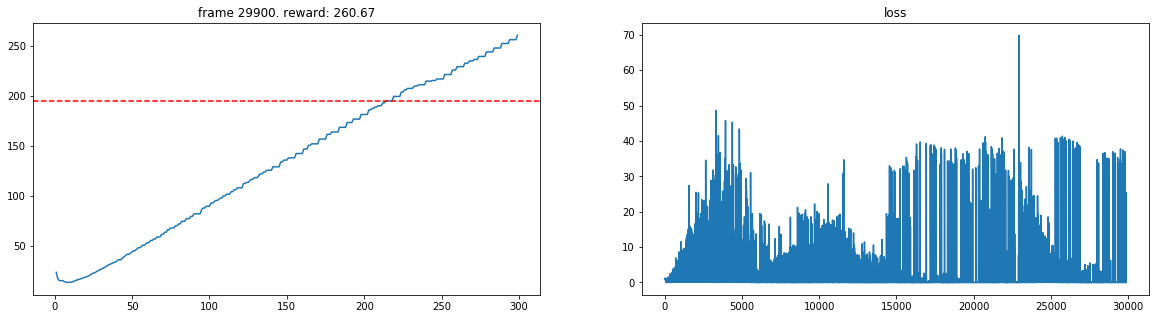

In [29]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
target_network = DQN(env.observation_space.shape[0], env.action_space.n)
opt = optim.Adam(model.parameters(), lr=LR)
target_opt = optim.Adam(target_network.parameters(), lr=LR)

train(model, target_network, opt, target_opt)

In [31]:
state = env.reset()
while True:
    env.render()
    action = model(torch.FloatTensor(state)).argmax().item()
    next_state, reward, done, _ = env.step(action)
    if done:
        break
    state = next_state
env.close()